# LIB basic inversion figures
This notebook uses the Molicel LIB to illustrate and validate the core techniques developed in this work - namely, hybrid impedance measurement and DRT-DOP inversion.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
from copy import deepcopy
from pathlib import Path

import hybdrt
from hybdrt.models import DRT
import hybdrt.fileload as fl
import hybdrt.plotting as hplt
import hybdrt.preprocessing as pp
from hybdrt.evaluation import DrtScorer, calculate_reg_metrics
from hybdrt.evaluation import chi_sq as chi_sq_score

import fig_funcs as ff

%load_ext autoreload
%autoreload 2

In [2]:
# Set plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()

data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)

# Figures will be saved here
ff.set_plotdir('./figures')

In [21]:
# Update datadir if you place the unzipped data archives in a different location
datadir = Path('../data/LIB/basic')

## DRT-DOP inversion with conventional EIS data
Demonstrate DRT-DOP inversion with conventional EIS data and compare to conventional DRT inversion.

In [5]:
# Set tau limits for DOP normalization
norm_tau = (1 / (2 * np.pi * 1e5), 1 / (2 * np.pi * 1e-2))

# Set DOP regularization strength (10:1 DRT:DOP ratio)
dop_l2_lambda_0 = 10

(1.5915494309189535e-06, 15.915494309189533)

In [6]:
# Load conventional EIS data
full_eis_file = datadir.joinpath(f'EISGALV_SOC=100%_IAC=120mA_10ppd.DTA')
eis_tup = fl.get_eis_tuple(full_eis_file)

# Fit with unconstrained conventional DRT
neg_drt = DRT(fit_dop=False)
neg_drt.fit_eis(*eis_tup, iw_l2_lambda_0=1e-6, nonneg=False, solve_rp=True)

# Fit with DRT-DOP
drt = DRT(fit_dop=True)
drt.fit_eis(*eis_tup, iw_l2_lambda_0=1e-6, nonneg=True, dop_l2_lambda_0=dop_l2_lambda_0)

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


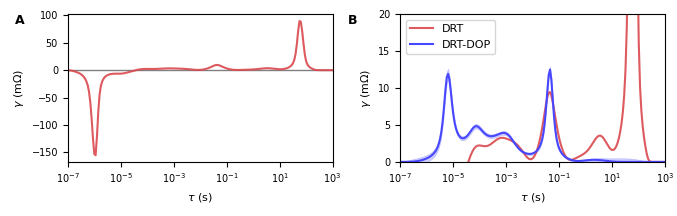

In [50]:
# Supp fig: compare conventional DRT to DRT-DOP
fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.32))

for ax in axes[:2]:
    neg_drt.plot_distribution(ax=ax, c=light_colors[1], alpha=0.9, label='DRT')
axes[0].axhline(0, c='grey', lw=1, zorder=-10)

drt.plot_distribution(ax=axes[1], c=light_colors[0], label='DRT-DOP', plot_ci=True)

for ax in axes:
    ax.set_xlim(1e-7, 1e3)
    
# Zoom in to show finer features
axes[1].set_ylim(0, 20)
axes[1].legend()


ff.add_letters(axes, loc=(-0.2, 1.0))

ff.savefig(fig, 'Supp_LIB_DRT_vs_DRTDOP_top', ext='png')

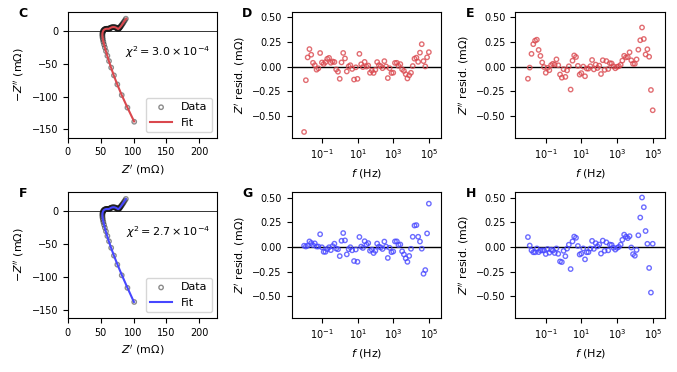

In [51]:
# Supp fig: residuals from conventional DRT and DRT-DOP
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.55))

axes[0, 0].get_shared_x_axes().join(*axes[:, 0])
axes[0, 0].get_shared_y_axes().join(*axes[:, 0])

axes[0, 1].get_shared_y_axes().join(*axes[:, 1:].ravel())

for i, drt_i in enumerate([neg_drt, drt]):
    drt_i.plot_eis_fit(plot_type='nyquist', axes=axes[i, 0], data_kw=data_kw, c=light_colors[1 - i],
                      label='Fit', data_label='Data')
    drt_i.plot_eis_residuals(axes=axes[i, 1:], scale_prefix='m', plot_sigma=False,
                             edgecolors=light_colors[1 - i], facecolors='none', alpha=0.8
                            )
    
    chi_sq = drt_i.evaluate_chi_sq(weights='modulus')
    pwr = np.floor(np.log10(chi_sq))
    axes[i, 0].text(0.95, 0.65, r'$\chi^2={:.1f} \times 10^{{{:.0f}}}$'.format(chi_sq / 10 ** pwr, pwr), 
                    transform=axes[i, 0].transAxes, 
                    ha='right')
    
for axrow in axes:
    axrow[1].set_ylabel('$Z^{\prime}$ resid. (m$\Omega$)')
    axrow[2].set_ylabel('$Z^{\prime\prime}$ resid. (m$\Omega$)')
    
ff.add_letters(axes, loc=(-0.33, 1.04), start_index=2)

ff.savefig(fig, 'Supp_LIB_DRT_vs_DRTDOP_bottom', ext='png')

### Separation of DRT and DOP components
Separate the DRT and DOP components of the conventional EIS spectrum.

In [11]:
# Separate DRT-DOP impedance contributions
# -----------------------------------------
drt_comp = {k: drt.copy() for k in ['DRT', 'HF', 'LF', '$R_{\infty}$']}

for key, drt_i in list(drt_comp.items()):
    drt_i.fit_parameters['inductance'] = 0
    if key != '$R_{\infty}$':
        drt_i.fit_parameters['R_inf'] = 0
    
for key in ['HF', 'LF', '$R_{\infty}$']:
    drt_comp[key].fit_parameters['x'] = np.zeros_like(drt.fit_parameters['x'])
    
pos_index = drt.basis_nu > 0
neg_index = drt.basis_nu < 0
drt_comp['LF'].fit_parameters['x_dop'][~neg_index] = 0
drt_comp['HF'].fit_parameters['x_dop'][~pos_index] = 0
drt_comp['$R_{\infty}$'].fit_parameters['x_dop'][drt.basis_nu != 0] = 0

drt_comp['DRT'].fit_parameters['x_dop'] = np.zeros_like(drt.fit_parameters['x_dop'])

(0.02856631796431131+0j)


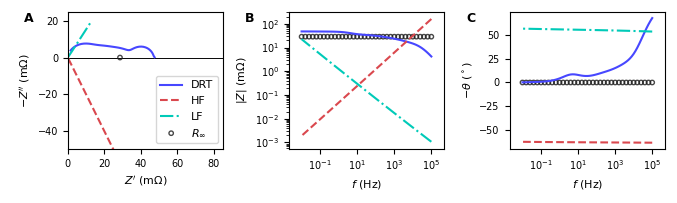

In [12]:
f_meas = eis_tup[0]

fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3))

colors = light_colors + ['k']
alphas = [1, 1, 1, 0.8]
ls = ['-', '--', '-.', '']

for i, (key, drt_i) in enumerate(drt_comp.items()):
    z_pred = drt_i.predict_z(f_meas) # + drt.predict_r_inf()

    
    if key == '$R_{\infty}$':
        print(z_pred[0])
        hplt.plot_nyquist((f_meas[:1], z_pred[:1]), ax=axes[0], scale_prefix='m', plot_func='scatter', 
                          label=key, **data_kw, alpha=alphas[i])
        hplt.plot_bode((f_meas[::2], z_pred[::2]), axes=axes[1:], scale_prefix='m', plot_func='scatter', 
                          label=key, **data_kw, alpha=alphas[i], log_mod=True)
    else:
        hplt.plot_eis((f_meas, z_pred), axes=axes, scale_prefix='m', plot_func='plot',
                  label=key, c=colors[i], alpha=alphas[i], ls=ls[i], bode_kw={'log_mod': True})
         
axes[0].set_ylim(-50, 25)
hplt.set_nyquist_aspect(axes[0], 'y')
xlim = axes[0].get_xlim()
axes[0].set_xlim(np.array(xlim) - xlim[0])

ff.add_letters(axes, loc=(-0.28, 1))
ff.savefig(fig, 'Supp_LIB_DRTDOP_separation')

## Hybrid measurement demonstration
Demonstrate the hybrid measurement technique with DRT-DOP inversion and compare to conventional EIS.

In [13]:
# Fit EIS and hybrid data
# ------------------------
# Use same tau grid for EIS and hybrid data
eis_drt = DRT(fit_dop=True, fixed_basis_tau=np.logspace(-7, 2, 91))
hy_drt = deepcopy(eis_drt)

# Conventional EIS file
full_eis_file = datadir.joinpath(f'EISGALV_SOC=100%_IAC=120mA_10ppd_Post.DTA')
full_eis_tup = fl.get_eis_tuple(full_eis_file)

# Independent 2nd conventional EIS measurement (EIS2)
eis_file_2 = datadir.joinpath(f'EISGALV_SOC=100%_IAC=120mA_10ppd.DTA')
eis_tup2 = fl.read_eis(eis_file_2, return_tuple=True)

# Geometric step data
geo_suffix = 'HybridGeo_Iac=120mA_Rest=2s_EisFirst'
geo_cp_file = datadir.joinpath(f'CHRONOP_{geo_suffix}.DTA')
geo_eis_file = datadir.joinpath(f'EISGALV_{geo_suffix}.DTA')

# Pulse data for comparison
pulse_cp_file = datadir.joinpath(f'CHRONOP_PulseDischarge_Iac=120mA.DTA')

cp_files = {
    'Geo': geo_cp_file,
    'Pulse': pulse_cp_file
}

fits = {}

eis_drt.fit_eis(*full_eis_tup, iw_l2_lambda_0=1e-6, dop_l2_lambda_0=dop_l2_lambda_0)
fits['EIS'] = deepcopy(eis_drt)

eis_drt.fit_eis(*eis_tup2, iw_l2_lambda_0=1e-6, dop_l2_lambda_0=dop_l2_lambda_0)
fits['EIS2'] = deepcopy(eis_drt)

f, z = full_eis_tup
f_5ppd = f[::2]
z_5ppd = z[::2]
eis_drt.fit_eis(f_5ppd, z_5ppd, iw_l2_lambda_0=1e-6, dop_l2_lambda_0=dop_l2_lambda_0)
fits['EIS_5ppd'] = deepcopy(eis_drt)

hy_fit_kw = dict(
    downsample=True,
    downsample_kw={
     'decimation_factor': 1.5,
     'method': 'decimate',
     'target_size': 1000,
     'antialiased': True
    },
    nonneg=True,
    iw_l2_lambda_0=1e-6,
    vz_offset=False,
    dop_l2_lambda_0=dop_l2_lambda_0
)


for key, cp_file in cp_files.items():
    # Use high-frequency portion of EIS2 file in hybrid fits for consistency, 
    # since hybrid EIS measurements were performed in galv mode
    hy_tup = fl.get_hybrid_tuple(cp_file, eis_file_2, False, max_freq=None, 
                                 start_time=-0.1, min_freq=99)
    hy_drt.fit_hybrid(*hy_tup, **hy_fit_kw)
    fits[key] = deepcopy(hy_drt)
    

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


14


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


41


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


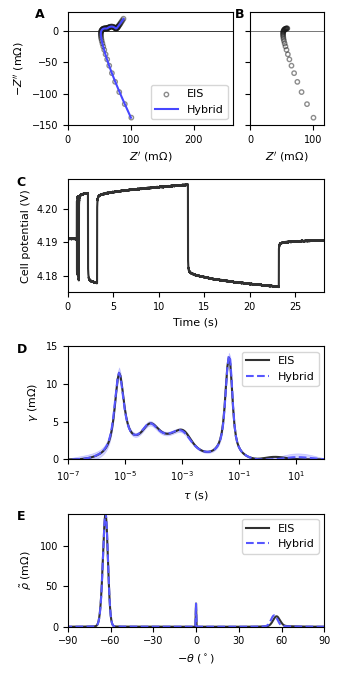

In [52]:
# Main text Figure 1: compare hybrid results to conventional EIS
# ----------------------------------------------------
fig = plt.figure(figsize=(0.5 * full_width, full_width))


gs = fig.add_gridspec(4, 3)

nyq_ax = fig.add_subplot(gs[0, :2])
hfz_ax = fig.add_subplot(gs[0, 2])
cp_ax = fig.add_subplot(gs[1, :])
drt_ax = fig.add_subplot(gs[2, :])
dop_ax = fig.add_subplot(gs[3, :])

axes = [nyq_ax, hfz_ax, cp_ax, drt_ax, dop_ax]

nyq_ax.get_shared_y_axes().join(nyq_ax, hfz_ax)

# nyq_ax = axes[0]
# cp_ax = axes[1]
# drt_ax = axes[2]
# dop_ax = axes[3]

freq, z_eis = full_eis_tup
hf_index = hybdrt.utils.array.nearest_index(freq, 100)
hplt.plot_nyquist((freq, z_eis), ax=nyq_ax, 
                  **data_kw, label='EIS')
hplt.plot_nyquist((freq[:hf_index], eis_tup2[1][:hf_index]), ax=hfz_ax, 
                  **data_kw)

hfz_ax.set_yticklabels([])
hfz_ax.set_ylabel('')

cp_df = fl.read_chrono(geo_cp_file)
hplt.plot_chrono(cp_df, axes=cp_ax, plot_i=False, plot_func='plot', c=data_kw['edgecolors'], alpha=0.9)
cp_ax.set_ylabel('Cell potential (V)')
cp_ax.set_xlim(0, cp_df['Time'].max())

eis_fmt = dict(c=data_kw['edgecolors'], alpha=0.9)
fits['EIS'].plot_distribution(ax=drt_ax, label='EIS', **eis_fmt)
fits['EIS'].plot_dop(ax=dop_ax, label='EIS', **eis_fmt,
                      normalize=True, normalize_tau=norm_tau)

hy_fmt = dict(c=ff.adjust_lightness(light_colors[0], 1.05), alpha=1.0, ls='--')
fits['Geo'].plot_distribution(ax=drt_ax, label='Hybrid', **hy_fmt, plot_ci=True)
fits['Geo'].plot_dop(ax=dop_ax, label='Hybrid', **hy_fmt,
                      normalize=True, normalize_tau=norm_tau)

# Plot impedance from hybrid
z_hy = fits['Geo'].predict_z(freq)
hplt.plot_nyquist((freq, z_hy), ax=nyq_ax, plot_func='plot', c=light_colors[0], label='Hybrid')

# hplt.plot_nyquist((freq[:hf_index], z_hy[:hf_index]), ax=nyq_ax, plot_func='plot', c=light_colors[1], label='Hybrid')

drt_ax.set_xlim(1e-7, 1e2)
drt_ax.set_ylim(0, 15)
dop_ax.set_xlim(-90, 90)
dop_ax.set_xticks(np.arange(-90, 90.1, 30))
dop_ax.set_ylim(0, 140)

# drt_ax.text(0.03, 0.95, '$r^2$: {:.3f}'.format(drt_scores['r2']), transform=drt_ax.transAxes, ha='left', va='top')
# dop_ax.text(0.03, 0.95, '$r^2$: {:.3f}'.format(dop_scores['r2']), transform=dop_ax.transAxes, ha='left', va='top')

for ax in [drt_ax, dop_ax]:
    ax.legend()
    
nyq_ax.set_ylim(-150, 30)
hplt.set_nyquist_aspect(nyq_ax)
hplt.set_nyquist_aspect(hfz_ax, 'y')
ff.zero_axlim(hfz_ax, 'x')
    
ff.add_letters(axes, loc=(-0.2, 1.03))

ff.savefig(fig, 'LIB_hybrid_demo', ext='png')

In [24]:
# Compare experiment durations
# -------------------------
zdf = fl.read_eis(eis_file_2)
t_eis = zdf.loc[zdf['Freq'] > 99, 'Time'].max()
cdf = fl.read_chrono(geo_cp_file)
t_cp = cdf['Time'].max()

# Add 2 s rest time
t_hyb = t_eis + t_cp + 2

print(f'HF EIS time: {t_eis} s') 
print(f'Chronopot time: {t_cp} s')
print('Rest time: 2.0 s')
print(f'Total hybrid time: {t_hyb} s')
# Check EIS duration
zdf1 = fl.read_eis(full_eis_file)
zdf2 = fl.read_eis(eis_file_2)

print('\n')

print('Conventional EIS time (minutes): {:.1f} for EIS1, {:.1f} for EIS2'.format(
    zdf1['Time'].max() / 60, zdf2['Time'].max() / 60
))
print('EIS:hybrid duration ratios: {:.1f} for EIS1, {:.1f} for EIS2'.format(
    zdf1['Time'].max() / t_hyb, zdf2['Time'].max() / t_hyb
))

HF EIS time: 9.442616 s
Chronopot time: 28.221 s
Rest time: 2.0 s
Total hybrid time: 39.663616 s


Conventional EIS time (minutes): 27.1 for EIS1, 30.6 for EIS2
EIS:hybrid duration ratios: 41.1 for EIS1, 46.3 for EIS2


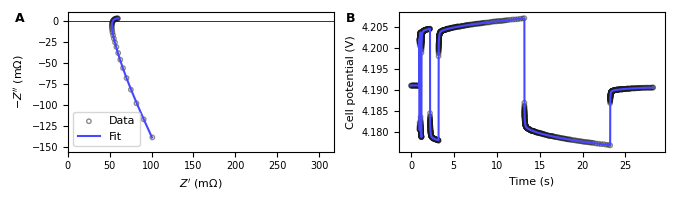

In [53]:
# Supp fig: show hybrid fit of raw data
fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.3))
fits['Geo'].plot_eis_fit(axes=axes[0], data_kw=data_kw | {'alpha': 0.5}, c=light_colors[0], alpha=1,
                        label='Fit', data_label='Data')
fits['Geo'].plot_chrono_fit(ax=axes[1], transform_time=False, data_kw=data_kw | {'alpha': 0.5}, 
                            c=light_colors[0], alpha=1)

axes[1].set_ylabel('Cell potential (V)')

fig.tight_layout()
hplt.set_nyquist_aspect(axes[0])

ff.add_letters(axes, loc=(-0.2, 1))
ff.savefig(fig, 'Supp_LIB_HybridFit_Top', ext='png')

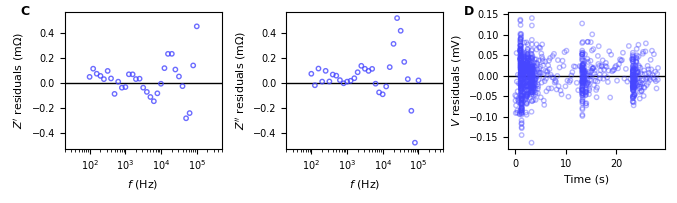

In [54]:
# Supp fig: hybrid fit residuals
fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3))

axes[0].get_shared_y_axes().join(*axes[:2])

fits['Geo'].plot_eis_residuals(axes=axes[:2], plot_sigma=False, edgecolors=light_colors[0],
                               facecolors='none', alpha=0.8, scale_prefix='m')
axes[0].set_ylabel('$Z^\prime$ residuals (m$\Omega$)')
axes[1].set_ylabel('$Z^{\prime\prime}$ residuals (m$\Omega$)')

fits['Geo'].plot_chrono_residuals(ax=axes[2], transform_time=False, plot_sigma=False,
                                 edgecolors=light_colors[0], facecolors='none',
                                  alpha=0.4, scale_prefix='m')
axes[2].set_ylabel('$V$ residuals (mV)')

fig.tight_layout()

ff.add_letters(axes[::2], start_index=2, loc=(-0.28, 1.05))
ff.savefig(fig, 'Supp_LIB_HybridFit_Bottom', ext='png')

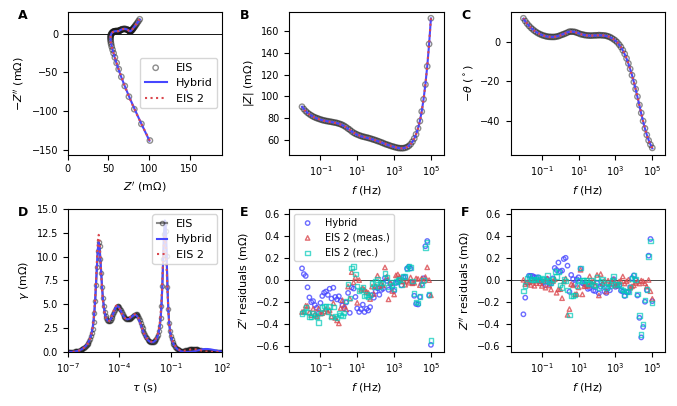

In [27]:
# Supp fig: Show impedance recovered from hybrid and compare to directly measured impedance
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.6))

f_meas = full_eis_tup[0]
z_pred = fits['Geo'].predict_z(f_meas)

bode_kw={'log_mod': False}
hplt.plot_eis(full_eis_tup, axes=axes[0], **data_kw, bode_kw=bode_kw, s=15, label='EIS')
hplt.plot_eis((f_meas, z_pred), axes=axes[0], plot_func='plot', bode_kw=bode_kw, label='Hybrid',
             c=light_colors[0])
hplt.plot_eis(eis_tup2, axes=axes[0], plot_func='plot', bode_kw=bode_kw, label='EIS 2', ls=':',
             c=light_colors[1])


resid_axes = axes[1, 1:]
z_err_eis = eis_tup2[1] - full_eis_tup[1]
z_err_hy = z_pred - full_eis_tup[1]
z_err_drt2 = fits['EIS2'].predict_z(f_meas) - full_eis_tup[1]

hplt.plot_bode((f_meas, z_err_hy), axes=resid_axes, cols=['Zreal', 'Zimag'], scale_prefix='m',
              edgecolors=light_colors[0], facecolors='none', alpha=0.8, label='Hybrid')
hplt.plot_bode((f_meas, z_err_eis), axes=resid_axes, cols=['Zreal', 'Zimag'], scale_prefix='m',
              edgecolors=light_colors[1], facecolors='none', alpha=0.8, label='EIS 2 (meas.)', marker='^')
hplt.plot_bode((f_meas, z_err_drt2), axes=resid_axes, cols=['Zreal', 'Zimag'], scale_prefix='m',
              edgecolors=light_colors[2], facecolors='none', alpha=0.7, label='EIS 2 (rec.)', marker='s')


for ax in resid_axes:
    ax.axhline(0, c='k', lw=0.5, zorder=-10)
    ax.set_ylim(-0.65, 0.65)

resid_axes[0].legend(fontsize=7, loc='upper left')
resid_axes[0].set_ylabel('$Z^\prime$ residuals (m$\Omega$)')
resid_axes[1].set_ylabel('$Z^{\prime\prime}$ residuals (m$\Omega$)')


ls = ['-', ':']
fits['EIS'].plot_distribution(ax=axes[1, 0], color=data_kw['edgecolors'], alpha=0.5, 
                              marker='o', markerfacecolor='none', ms=3,
                              label='EIS'
                             )
for i, (key, label) in enumerate(zip(['Geo', 'EIS2'], ['Hybrid', 'EIS 2'])):
    fit = fits[key]
    fit.plot_distribution(ax=axes[1, 0], ls=ls[i], c=light_colors[i], label=label)
    
axes[1, 0].set_xlim(10 ** -7, 10 ** 2)
axes[1, 0].set_ylim(0, 15)
axes[1, 0].legend(handlelength=0.9, loc='upper right')

# axes[0, 1].set_yscale('linear')
ff.add_letters(axes, loc=(-0.32, 1.02))

ff.savefig(fig, 'Supp_LIB_Hybrid-Z-Validation')

### Comparison to low-density EIS and pulse CP
As a benchmark, compare hybrid geometric results to alternatives: low-density EIS and hybrid with time-domain pulse step.

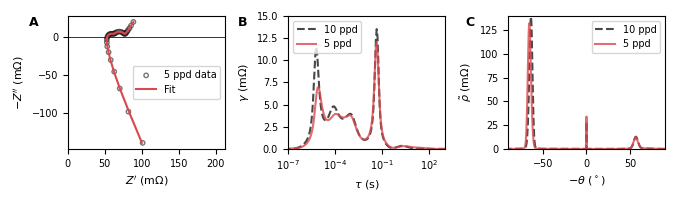

In [30]:
# Compare EIS with 5 ppd to EIS with 10 ppd
fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3))

fits['EIS_5ppd'].plot_eis_fit(axes=axes[0], data_kw=data_kw | {'alpha': 0.6}, c=light_colors[1],
                             data_label='5 ppd data', label='Fit')

for key in ['EIS', 'EIS_5ppd']:
    
    if key == 'EIS':
        label = '10 ppd'
        kw = {'c': data_kw['edgecolors'], 'alpha': 0.8, 'ls': '--'}
    else:
        label = '5 ppd'
        kw = {'c': light_colors[1], 'ls':'-', 'alpha': 0.8}
    fit = fits[key]
    fit.plot_distribution(ax=axes[1], label=label, **kw)
    fit.plot_dop(ax=axes[2], normalize=True, normalize_tau=norm_tau, label=label, **kw)
    
axes[0].legend(fontsize=7)
axes[1].legend(fontsize=7)
axes[2].legend(fontsize=7)
    
axes[1].set_xlim(1e-7, 1e3)
axes[1].set_ylim(0, 15)

axes[2].set_xlim(-90, 90)
axes[2].set_ylim(0, 140)
    
fig.tight_layout()
ff.add_letters(axes, loc=[(-0.25, 1), (-0.32, 1), (-0.27, 1)])
ff.savefig(fig, 'Supp_LIB_5ppdEIS')

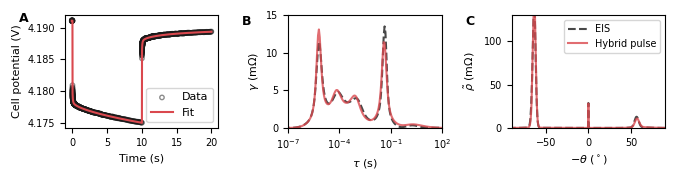

In [ ]:
# Compare hybrid measurement with pulse signal to EIS
fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.27))


bins=np.arange(-3, 1.1, 0.5)
bin_width = np.mean(np.diff(bins))

hist_kw = dict(
    bins=bins / bin_width, histtype='step',
    ls='--', density=True
)


# PLot data and fit
fits['Pulse'].plot_chrono_fit(ax=axes[0], transform_time=False, data_kw=data_kw, c=light_colors[1],
                         label='Fit', data_label='Data')
axes[0].legend()
axes[0].set_ylabel('Cell potential (V)')
    
    
# for ax in axes[1]:
#     ax.set_yscale('log')
#     ax.set_xlabel('$\log_{10}(t - t_s)$')
#     ax.set_ylabel('Fraction of samples')
# axes[1, 0].legend(loc='upper left')

fits['EIS'].plot_distribution(ax=axes[1], c=data_kw['edgecolors'], alpha=0.8, label='EIS', ls='--')
fits['Pulse'].plot_distribution(ax=axes[1], c=light_colors[1], alpha=0.8, label='Hybrid pulse', ls='-')
# fits['Geo'].plot_distribution(ax=axes[1, 1], c=light_colors[0], alpha=1, label='Geometric')

fits['EIS'].plot_dop(ax=axes[2], c=data_kw['edgecolors'], alpha=0.8, label='EIS', ls='--',
                     normalize=True, normalize_tau=norm_tau)
fits['Pulse'].plot_dop(ax=axes[2], c=light_colors[1], alpha=0.8, label='Hybrid pulse', ls='-',
                       normalize=True, normalize_tau=norm_tau)


axes[2].legend(fontsize=7)
    
axes[1].set_xlim(1e-7, 1e2)
axes[1].set_ylim(0, 15)
axes[2].set_xlim(-90, 90)
axes[2].set_ylim(0, 130)
    
fig.tight_layout()

# loci = [(-0.19, 1.01)] * 2 + [(-0.19, 1)] * 2
ff.add_letters(axes, loc=[(-0.3, 1.03)] + [(-0.3, 1)] * 2)
ff.savefig(fig, 'Supp_LIB_HybridPulse')

## Time-domain-only inversion

Demonstrate DRT-DOP estimation with time-domain data only.

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
14


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


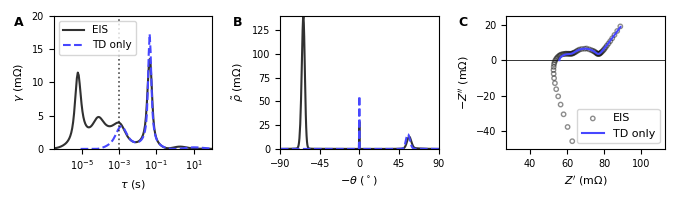

In [31]:
# Compare to time-domain-only inversion
# Here we only consider the pseudo-capacitive DOP range (nu < 0),
# since pseudo-inductive effects are negligible at longer timescales
cp_drt = DRT(fit_dop=True, fit_inductance=False, fixed_basis_nu=np.linspace(-1, -0.4, 25))
cp_tup = fl.get_chrono_tuple(geo_cp_file)
cp_drt.fit_chrono(*cp_tup, **hy_fit_kw)

fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.3))

hy_kw = dict(c=data_kw['edgecolors'], alpha=0.9, label='EIS', ls='-')
cp_kw = dict(c=ff.adjust_lightness(light_colors[0], 1.0), ls='--', label='TD only')

fits['EIS'].plot_distribution(ax=axes[0], **hy_kw)
# fits['Geo'].plot_distribution(ax=axes[0], **hy_kw)
cp_drt.plot_distribution(ax=axes[0], **cp_kw)
axes[0].set_xlim(10 ** -6.5, 1e2)
axes[0].set_ylim(0, 20)
axes[0].legend(loc='upper left', fontsize=7.5)

dop_kw = {'normalize': True, 'normalize_tau': norm_tau, 'ax': axes[1]}
fits['EIS'].plot_dop(**dop_kw, **hy_kw)
cp_drt.plot_dop(**dop_kw, **cp_kw)
axes[1].set_xlim(-90, 90)
axes[1].set_xticks(np.arange(-90, 90.1, 45))
axes[1].set_ylim(0, 140)


axes[0].axvline(1e-3, ls=':', c='k', lw=1.2, alpha=0.7)

freq, z_eis = full_eis_tup
z_cp = cp_drt.predict_z(freq)
z_hy = fits['EIS'].predict_z(freq)

hplt.plot_nyquist(full_eis_tup, ax=axes[2], label='EIS', **data_kw, alpha=0.5)
hplt.plot_nyquist((freq, z_cp), ax=axes[2], plot_func='plot', **cp_kw | {'ls': '-'})

axes[2].set_ylim(-50, 25)
hplt.set_nyquist_aspect(axes[2], 'y', center_coords=(70, -12.5))

# axes[0].legend()
# axes[2].get_legend().remove()

fig.tight_layout()

ff.add_letters(axes, loc=[(-0.25, 1)] + [(-0.3, 1)] * 2)
ff.savefig(fig, 'Supp_LIB_PureChrono')

## Score results
Assign scores based on similarity to reference EIS results.

In [47]:
# Quantify match between EIS and hybrid
ds = DrtScorer()

match_scores = {}

# Get DOP for manual eval
nu_eval = np.linspace(-1, 1, 101)
rho_eis = fits['EIS'].predict_dop(nu_eval, normalize=True, normalize_tau=norm_tau)

# Compare DRT and DOP
for key in ['Geo', 'EIS2', 'Pulse', 'EIS_5ppd']:
    drt_scores = ds.evaluate_models(fits['EIS'], fits[key], tau_reg=np.logspace(-7, 3, 101), 
                                    tau_cls=np.logspace(-7, 3, 101))
    
    rho_compare = fits[key].predict_dop(nu_eval, normalize=True, normalize_tau=norm_tau)
    _, dop_scores = calculate_reg_metrics(np.exp(nu_eval), rho_eis, rho_compare, False)

#     print(key, drt_scores['r2'], dop_scores['f_kl'])
    match_scores[key] = {'DRT': drt_scores, 'DOP': dop_scores}

# Compare impedance
f1, z1 = full_eis_tup
zmod = np.abs(z1)

for key in list(match_scores.keys()):
    if key == 'EIS2':
        z2 = fits[key].z_fit
    else:
        z2 = fits[key].predict_z(f1)
        
    match_scores[key]['Z'] = {'chi_sq': chi_sq_score(z1, z2, weights=1 / zmod)}

False
thresh: 0.030638324232411026
thresh: 0.032154272532184586
False
thresh: 0.030638324232411026
thresh: 0.027714193647354796
False
thresh: 0.030638324232411026
thresh: 0.027892797794605653
False
thresh: 0.030638324232411026
thresh: 0.023799731918656645


In [48]:
table_data = []
for k, v in match_scores.items():
    scores = match_scores[k]
    row_data = [scores['DRT']['r2'], scores['DOP']['r2'], scores['Z']['chi_sq']]
    table_data.append(row_data)

# table_data = np.array(table_data)
# col_names = ['Data source', 'DRT r2', 'DRT f_kl', 'DOP r2', 'DOP f_kl', 'Z chi_sq']
ff.format_table(table_data, fmt='.3f')
print(list(match_scores.keys()))

0.997 & 0.997 & 0.001\\
0.992 & 0.997 & 0.000\\
0.974 & 0.994 & 0.001\\
0.889 & 0.634 & 0.001
['Geo', 'EIS2', 'Pulse', 'EIS_5ppd']


In [49]:
# Get formatted chi_sq values
print('\n'.join([ff.sci_not(x, 1) for x in np.array(table_data)[:, -1]]))

$6.0 \times 10^{-4}$
$4.8 \times 10^{-4}$
$1.3 \times 10^{-3}$
$5.9 \times 10^{-4}$


In [42]:
# Check chi_sq for EIS 2 using DRT fit instead of raw data
z2 = fits['EIS2'].predict_z(f1)
x2 = chi_sq_score(z1, z2, weights=1 / zmod)
ff.sci_not(x2, 1)

'$6.3 \\times 10^{-4}$'

## Compare data density for pulse and geometric steps
Illustrate the geometric step and show how it changes the density of samples by timescale.

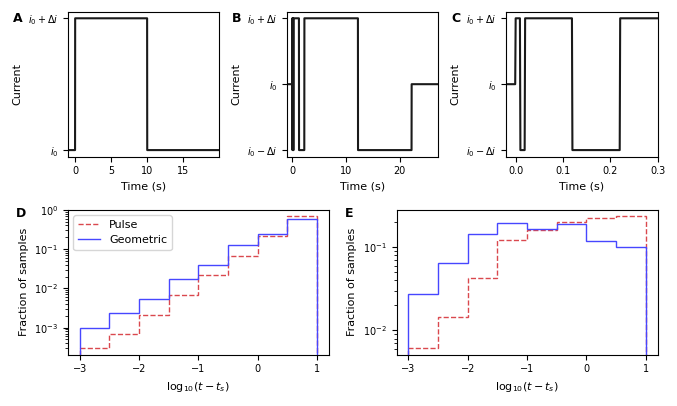

In [ ]:
# Supp fig: Compare Geo to Pulse in terms of data density
# ----------------------------------------------
# fig, axes = plt.subplots(2, 2, figsize=(full_width, full_width * 0.55))
fig = plt.figure(figsize=(full_width, full_width * 0.6))
gs = fig.add_gridspec(2, 6)

top_axes = [fig.add_subplot(gs[0, 2 * i:2 * (i + 1)]) for i in range(3)]
bot_axes = [fig.add_subplot(gs[1, 3 * i:3 * (i + 1)]) for i in range(2)]
# axes = np.array([top_axes[:2], bot_axes])

# axes[0, 0].get_shared_y_axes().join(*axes[0])


bins=np.arange(-3, 1.1, 0.5)
bin_width = np.mean(np.diff(bins))

hist_kw = dict(
    bins=bins / bin_width, histtype='step',
    ls='--', density=True
)

ls = ['--', '-']
for i, (key, label) in enumerate(zip(['Pulse', 'Geo'], ['Pulse', 'Geometric'])):
    fit = fits[key]
    cp_tup = fl.read_chrono(cp_files[key], return_tuple=True)
    # Get time deltas for full and downsample datasets
    full_td = pp.get_time_since_step(cp_tup[0], fit.nonconsec_step_times)
    ds_td = pp.get_time_since_step(fit.get_fit_times(), fit.nonconsec_step_times)
    
    # Plot idealized current signal
    times, i_sig, _ = cp_tup
    step_index = pp.identify_steps(i_sig)[0]
    t0 = times[step_index]
    i_max = np.max(np.abs(i_sig))
    i_sig = np.round(i_sig / i_max, 0)
    if key == 'Pulse':
        i_sig *= -1
    top_axes[i].plot(times - t0, i_sig, c=data_kw['edgecolors'])
    top_axes[i].set_ylabel('Current')
    top_axes[i].set_xlim(-1, np.max(times - t0))
    top_axes[i].set_xlabel('Time (s)')
#     axes[0, i].set_xscale('log')
#     axes[0, i].set_xlim(1e-3, np.max(times - t0))

    if key == 'Geo':
        top_axes[2].plot(times - t0, i_sig, c=data_kw['edgecolors'])
        top_axes[2].set_ylabel('Current')
        top_axes[2].set_xlim(-0.02, 0.3)
        top_axes[2].set_xlabel('Time (s)')
    
    # histograms
    for j, td in enumerate([full_td, ds_td]):
        # A few points show up just below -3 due to precision loss/rounding
        # Bump these up to -3
        log_td = np.maximum(-3, np.log10(td))
        counts, _ = np.histogram(log_td, bins=bins)
    
        bot_axes[j].stairs(counts / np.sum(counts), bins, color=light_colors[1 - i], ls=ls[i], label=label)
        
    
top_axes[0].set_yticks([0, 1])
top_axes[0].set_yticklabels(['$i_0$', '$i_0 + \Delta i$'])

for ax in top_axes[1:]:
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(['$i_0 - \Delta i$', '$i_0$', '$i_0 + \Delta i$'])

for ax in bot_axes:
    ax.set_yscale('log')
    ax.set_xlabel('$\log_{10}(t - t_s)$')
    ax.set_ylabel('Fraction of samples')
bot_axes[0].legend(loc='upper left')

# Pulse fit
# fits['Pulse'].plot_chrono_fit(ax=axes[1, 0], transform_time=False, data_kw=data_kw, c=light_colors[1],
#                              label='Fit', data_label='Pulse data')
# axes[1, 0].legend()
# axes[1, 0].set_ylabel('Cell potential (V)')
    
fig.tight_layout()

# loci = [(-0.19, 1.01)] * 2 + [(-0.19, 1.08)] * 2 + [(-0.19, 1)] * 2
ff.add_letters(top_axes, loc=(-0.365, 1.0))
ff.add_letters(bot_axes, loc=(-0.2, 1.02), start_index=3)
ff.savefig(fig, 'Supp_GeoStep')

## Time-domain extrapolation
Use the DRT and DRT-DOP models to predict time-domain voltage.

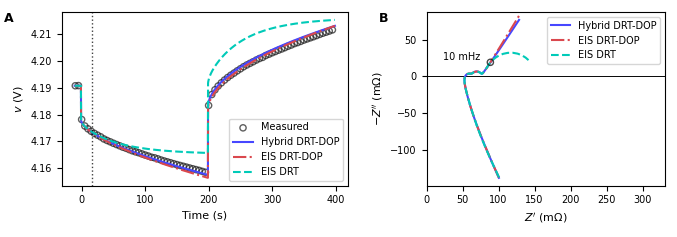

In [43]:
long_cp_file = 'CHRONOP_PulseLong_Iac=120mA.DTA'
long_cp_df = fl.read_chrono(os.path.join(datadir, long_cp_file))

long_t, long_i, long_v = fl.get_chrono_tuple(long_cp_df)
# Offset to place step at 0
t_step = 1
long_t -= t_step
# Get starting voltage
v_baseline = np.median(long_v[long_t < 0])

# fig, axes = plt.subplots(1, 2, figsize=(full_width, full_width * 0.35))
fig = plt.figure(figsize=(full_width, full_width * 0.35))
gs = fig.add_gridspec(1, 2, width_ratios=(1.2, 1.))
axes = [fig.add_subplot(gs[i]) for i in range(2)]

eis_ax = axes[1]
cp_ax = axes[0]

# hplt.plot_chrono(long_cp_df[long_t < 1][::2], axes=axes[0], plot_i=False, label='', alpha=0.25, s=20, **data_kw)
hplt.plot_chrono(long_cp_df[::50], axes=cp_ax, plot_i=False, alpha=0.7, s=20, **data_kw,
                label='Measured')
# Plot one point at higher alpha for legend handle
# hplt.plot_chrono((long_t[:1], long_i[:1], long_v[:1]), axes=axes[0], plot_i=False, 
#                  label='Measured', alpha=0.5, s=20, **data_kw)
# hplt.plot_chrono(cp_data, axes=ax, plot_i=False)

v_predictions = {}
z_predictions = {}
f_pred = np.logspace(5, -3, 81)
for fit, label in zip(
    [fits['Geo'],  fits['EIS'], neg_drt],
    ['Hybrid DRT-DOP', 'EIS DRT-DOP', 'EIS DRT']
):
    v_pred = fit.predict_response(long_t, long_i, v_baseline=0)
    v_predictions[label] = v_pred
    z_predictions[label] = fit.predict_z(f_pred)
    
ls = ['-', '-.', '--']
for i, (key, v_pred) in enumerate(v_predictions.items()):
    cp_ax.plot(long_t, v_pred + v_baseline, color=light_colors[i], label=key, ls=ls[i])
    hplt.plot_nyquist((f_pred, z_predictions[key]), ax=eis_ax, label=key,
                     color=light_colors[i], plot_func='plot', ls=ls[i])
    
cp_ax.axvline(16, c='k', ls=':', lw=1, alpha=0.75)
# axes[0]

f_min = np.array([0.01])
z_min = fits['EIS'].predict_z(f_min)
hplt.plot_nyquist((f_min, z_min), ax=eis_ax, **data_kw, s=20, alpha=0.8, zorder=10)
eis_ax.text(75, 22, '10 mHz', ha='right', fontsize=7)


for ax in axes:
    ax.legend(fontsize=7)
    

fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
ff.add_letters(axes, loc=(-0.2, 1))  # loc=[(-0.17, 1), (-0.17, 1)])

ff.savefig(fig, 'Supp_LIB_Extrapolation')